# JPX - Feature Engineering + BackTest + Submission

This notebook is inspired by the 2nd winning solution from the past JPX competition. I will train on data from 2017 to 2020 and backtest for 2020+.

I also prepare the submission file for a end to end notebook.

Here is the link of the winners solutions:
https://www.jpx.co.jp/english/corporate/news/news-releases/0010/20210813-01.html

Here is the diagram used, I am focusing only on the technical indicators part
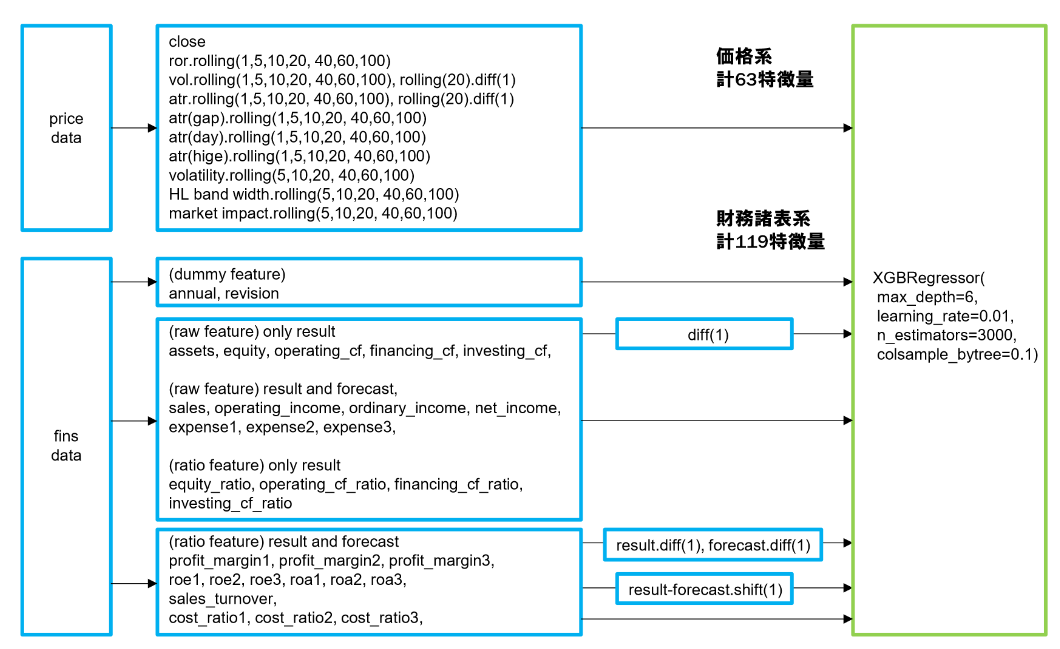

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from lightgbm import LGBMRegressor
import plotly.graph_objects as go

def calc_return(X,targets, keep_n):
    '''My home made function to do the weighted score'''
    n_stocks = X.shape[1]
    longs = (X<keep_n)*1
    shorts = (X>(n_stocks- keep_n - 1))*1

    if keep_n>1:
        longs = ((1-(X/(keep_n-1)))+1)*longs/(3*keep_n)
        shorts = -((X-(n_stocks- keep_n))/(keep_n-1)+1)*shorts/(3*keep_n)
    else:
        longs = longs/2
        shorts = -shorts/2
    return (targets*(shorts+longs)).sum(axis=1)


In [ ]:
df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
df.Date = pd.to_datetime(df.Date)

# Feature engineering

We use rolling-based methods to create new features. In order to do so, we first need to "pivot" the initial dataset to make sure that rolling features are applying stock by stock. Once a feature is created, we can simply use the "melt" method and join the new feature with our current feature matrice on both "Date" and "SecuritiesCode"

This pivot/melt/join method allow to make this feature engineering in a clean and easy way

In [ ]:
targets = pd.pivot_table(df, values = "Target", index = "Date", columns = "SecuritiesCode")
closes = pd.pivot_table(df, values = "Close", index = "Date", columns = "SecuritiesCode").ffill()
opens = pd.pivot_table(df, values = "Open", index = "Date", columns = "SecuritiesCode").ffill()
highs = pd.pivot_table(df, values = "High", index = "Date", columns = "SecuritiesCode").ffill()
lows = pd.pivot_table(df, values = "Low", index = "Date", columns = "SecuritiesCode").ffill()
volumes = pd.pivot_table(df, values = "Volume", index = "Date", columns = "SecuritiesCode").ffill()

In [ ]:
def ror(window):
    
    return pd.melt((closes - closes.shift(window))/closes.shift(window),ignore_index=False).reset_index().dropna().rename(columns = {"value":f"ror_{window}"})

def vol(window):
    
    return pd.melt(volumes.rolling(window).mean(),ignore_index=False).reset_index().dropna().rename(columns = {"value":f"vol_{window}"})

def atr(window):
    
    a = highs - lows
    b = abs(highs - closes.shift(1))
    c = abs(lows - closes.shift(1))
    return pd.melt(pd.DataFrame(np.max([a,b,c], axis = 0), index = a.index, columns = a.columns).rolling(window).mean(),ignore_index=False).reset_index().dropna().rename(columns = {"value":f"atr_{window}"})

def atr_day(window):
    
    a = highs - lows

    return pd.melt(a.rolling(window).mean(),ignore_index=False).reset_index().dropna().rename(columns = {"value":f"atrday_{window}"})

def atr_gap(window):
    
    a = abs(highs - closes.shift(1))

    return pd.melt(a.rolling(window).mean(),ignore_index=False).reset_index().dropna().rename(columns = {"value":f"atrgap_{window}"})

def atr_hige(window):
    
    a = abs(lows - closes.shift(1))

    return pd.melt(a.rolling(window).mean(),ignore_index=False).reset_index().dropna().rename(columns = {"value":f"atrhige_{window}"})

def dev(window):
    return pd.melt((closes.diff()/closes.shift(1)).rolling(window).std(),ignore_index=False).reset_index().dropna().rename(columns = {"value":f"variation_{window}"})

def HL(window):
    return pd.melt((highs.rolling(window).max()-lows.rolling(window).min()),ignore_index=False).reset_index().dropna().rename(columns = {"value":f"HL_{window}"})

def market_impact(window):
    return pd.melt((closes.diff()/volumes).rolling(window).mean(),ignore_index=False).reset_index().dropna().rename(columns = {"value":f"market_imact_{window}"})

## Build feature matrice

In [ ]:
features = df[["Date","SecuritiesCode","Close","ExpectedDividend"]].fillna(0)

for func in [ror, vol, atr, atr_day, atr_gap, atr_hige, HL, market_impact]:
    for window in tqdm([1,5,10,20,40,60,100]):
        features = pd.merge(features, func(window), on = ["Date","SecuritiesCode"], how = "left")
    
for window in tqdm([2,5,10,20,40,60,100]):
    features = pd.merge(features, dev(window), on = ["Date","SecuritiesCode"], how = "left")

features["vol_diff"] = features["vol_20"].diff()   
features["atr_diff"] = features["atr_20"].diff()   

# Model training

The model is trained on data up to 2020, and the 2020-2021 period is used to evaluated the perfomances.

In [ ]:
X = features.fillna(0)
y = df["Target"]

Xtrain = X.loc[(X.Date<"2020-01-01")].drop("Date",axis=1).astype(np.float32)
ytrain = y.loc[Xtrain.index]

m = LGBMRegressor()
m.fit(Xtrain,ytrain)

# Backtest

In order to backtest the model, we associate to each prediction a date and a stock, and pivot the prediction column to match it with the target matrices.

In [ ]:
subdf = df.loc[(df.Date>"2020-01-01")]
Xtest = X.loc[(X.Date>"2020-01-01")].drop("Date",axis=1).astype(np.float32)

targets_2020plus = pd.pivot_table(subdf, index = "Date", columns = "SecuritiesCode", values="Target")
subdf["predictions"] = m.predict(Xtest)
preds = pd.pivot_table(subdf, index = "Date", columns = "SecuritiesCode", values="predictions").reindex(targets_2020plus.index).ffill().bfill()

In [ ]:
buy_sell_2020plus = 1999-np.argsort(np.argsort(preds))
portfolio_return = calc_return(buy_sell_2020plus, targets_2020plus, 200)
average_index_return = targets_2020plus.mean(axis=1)
print(f"daily sharp ratio, lgb model : {np.round(portfolio_return.mean()/portfolio_return.std(),3)}")
print(f"daily sharp ratio, average index: {np.round(average_index_return.mean()/portfolio_return.std(),3)}")

fig = go.Figure()
fig.add_traces(
    go.Scatter(
        x = portfolio_return.index,
        y = portfolio_return.cumsum(),
        name = "lgb strategy"
    )
)

fig.add_traces(
    go.Scatter(
        x = average_index_return.index,
        y = average_index_return.cumsum(),
        name = "average index"
    )
)

fig.update_layout(template = "presentation")
fig.show()

# Prepare submission

In [ ]:
import jpx_tokyo_market_prediction

closes = pd.pivot_table(df, values = "Close", index = "Date", columns = "SecuritiesCode").ffill().iloc[-101:]
opens = pd.pivot_table(df, values = "Open", index = "Date", columns = "SecuritiesCode").ffill().iloc[-101:]
highs = pd.pivot_table(df, values = "High", index = "Date", columns = "SecuritiesCode").ffill().iloc[-101:]
lows = pd.pivot_table(df, values = "Low", index = "Date", columns = "SecuritiesCode").ffill().iloc[-101:]
volumes = pd.pivot_table(df, values = "Volume", index = "Date", columns = "SecuritiesCode").ffill().iloc[-101:]

env = jpx_tokyo_market_prediction.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files
for (prices, _, _, _, _, sample_prediction) in iter_test:
    
    prices.Date = pd.to_datetime(prices.Date)
    date = prices.Date.iloc[0]

    #Update tables
    _closes = pd.pivot_table(prices, values = "Close", columns = "SecuritiesCode", index = "Date")
    _opens = pd.pivot_table(prices, values = "Open", columns = "SecuritiesCode", index = "Date")
    _highs = pd.pivot_table(prices, values = "High", columns = "SecuritiesCode", index = "Date")
    _lows = pd.pivot_table(prices, values = "Low", columns = "SecuritiesCode", index = "Date")
    _volumes = pd.pivot_table(prices, values = "Volume", columns = "SecuritiesCode", index = "Date")

    closes = pd.concat([closes, _closes]).ffill().iloc[-101:]
    opens = pd.concat([opens, _opens]).ffill().iloc[-101:]
    highs = pd.concat([highs, _highs]).ffill().iloc[-101:]
    lows = pd.concat([lows, _lows]).ffill().iloc[-101:]
    volumes = pd.concat([volumes, _volumes]).ffill().iloc[-101:]

    features = prices[["Date","SecuritiesCode","Close","ExpectedDividend"]].fillna(0)

    for func in [ror, vol, atr, atr_day, atr_gap, atr_hige, HL, market_impact]:
        for window in tqdm([1,5,10,20,40,60,100]):
            features = pd.merge(features, func(window), on = ["Date","SecuritiesCode"], how = "left")

    for window in tqdm([2,5,10,20,40,60,100]):
        features = pd.merge(features, dev(window), on = ["Date","SecuritiesCode"], how = "left")

    features["vol_diff"] = features["vol_20"].diff()   
    features["atr_diff"] = features["atr_20"].diff()

    prices["pred"] = 1999-np.argsort(np.argsort(m.predict(features.drop(['Date'],axis=1))))
    sample_prediction['Rank'] = prices.set_index("SecuritiesCode")["pred"].reindex(sample_prediction["SecuritiesCode"]).values
    
    env.predict(sample_prediction)